In [1]:
import os
import glob
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import time
import PIL
import imageio
from GMM import sample_GMM, GMM_distribution
from IPython import display

import tensorflow as tf
from tensorflow.keras import datasets, layers, Sequential, Model
from tensorflow.keras import metrics
from tensorflow.keras import constraints

tf.__version__

'2.1.0'

In [2]:
# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['NCCL_TOPOLOGY'] = 'CUBEMESH'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Data

In [4]:
num_disc = 10
target_size = 5000

## load GMM data

In [5]:
with open('gmm_data.pkl', 'rb') as f:
    GMM_dataset = pickle.load(f)

In [6]:
GMM_dataset.data['samples'].shape, GMM_dataset.data['labels'].shape, GMM_dataset.data['density'].shape

((10000, 2), (10000,), (10000,))

In [7]:
train_dataset = GMM_dataset.data['samples'][:target_size].astype('float32')
train_labels = GMM_dataset.data['labels'][:target_size].astype('float32')

test_dataset = GMM_dataset.data['samples'][target_size:].astype('float32')
test_labels = GMM_dataset.data['labels'][target_size:].astype('float32')

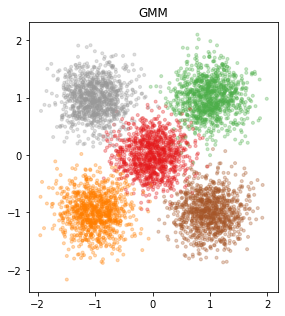

In [8]:
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax = axes
ax.set_aspect('equal')
ax.axis('on')
ax.set_title('GMM')

axes.scatter(train_dataset[:, 0],
             train_dataset[:, 1],
             marker='.',
             c=cm.Set1(train_labels.astype(float) / 2.0 / 2.0),
             alpha=0.3)
plt.tight_layout()
#     plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

## split to target and shadow

In [9]:
def EvenlySplitting(dataset, size=5):
    chunk_size = dataset.shape[0]//size
    
    splitted_datasets = []
    for i in range(size):
        temp_data = dataset[i*chunk_size:(i+1)*chunk_size]
        splitted_datasets.append(temp_data)
        
    return splitted_datasets

In [10]:
target_partions = EvenlySplitting(train_dataset, size=num_disc)

In [11]:
len(target_partions)

10

In [12]:
target_partions[0].shape

(500, 2)

# Build GAN

In [13]:
noise_dim = 2
nrow = train_dataset.shape[1]
# ncol = train_dataset.shape[2]
# channels = train_dataset.shape[3]
# input_shape = (nrow, ncol, channels)

## Generator

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(2, )))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(2))
    assert model.output_shape == (None, 2)  # Note: None is the batch size

    return model

In [15]:
generator = make_generator_model()

noise = tf.random.normal([1, 2])
generated_sample = generator(noise, training=False)
generated_sample

# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.04050839, -0.03557189]], dtype=float32)>

## Discriminator

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(2, )))
    model.add(layers.LeakyReLU())
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout())
    
#     model.add(layers.Dense(256))
#     model.add(layers.LeakyReLU())
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout())
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [17]:
# Use the (as yet untrained) discriminator 
# to classify the generated images as real or fake.
discriminators = []
for i in range(num_disc):
    discriminators.append(make_discriminator_model())

In [18]:
# check output, two outputs are different, which means discriminators are independent.
for i in range(num_disc):
    disc_output = discriminators[i](generated_sample, training=False)
    print (disc_output)

tf.Tensor([[0.50008696]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5009206]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.49826518]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.50000507]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5004618]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5002639]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.50078183]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.50051516]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4982488]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.50058293]], shape=(1, 1), dtype=float32)


## Loss

In [19]:
# cross_entropy_loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizer

In [20]:
# Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)
# generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
# discriminator_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

# Training

In [21]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 1000
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig, axes= plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
    axes.set_xlim(-2, 2)
    axes.set_ylim(-2, 2)
    axes.set_aspect('equal')
    axes.axis('on')
    axes.set_title('generated_GMM-epoch{}'.format(epoch))
    
    axes.scatter(predictions[:, 0],
                 predictions[:, 1],
                 marker='.',
#                  c=cm.Set1(targets.astype(float) / 2.0 / 2.0),
                 alpha=0.3)
    plt.tight_layout()
    # plt.savefig('images/epoch_{:04d}.png'.format(epoch))
    plt.show()

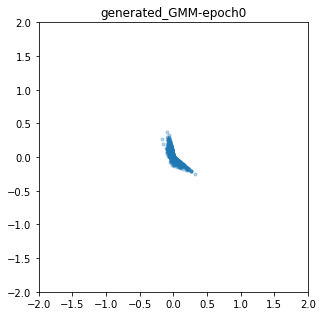

In [23]:
generate_and_save_images(generator, 0, seed)

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch_size, zipped_real_samples):
    # update D
    for _ in range(2):
        all_disc_loss = []
        # for each discriminator
        for i in range(num_disc):            
            noise = tf.random.normal([batch_size, noise_dim])
            with tf.GradientTape() as disc_tape:            
                generated_samples = generator(noise, training=True)
                real_output = discriminators[i](zipped_real_samples[i], training=True)
                fake_output = discriminators[i](generated_samples, training=True)

                disc_loss = discriminator_loss(real_output, fake_output)

                gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminators[i].trainable_variables)
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                            discriminators[i].trainable_variables))
            all_disc_loss.append(disc_loss)
    
    # update G
    for _ in range(1):
        with tf.GradientTape() as gen_tape:
            all_gen_loss = []
            for i in range(num_disc):
                noise = tf.random.normal([batch_size, noise_dim])
                generated_samples = generator(noise, training=True)
                fake_output = discriminators[i](generated_samples, training=True)        
                gen_loss = generator_loss(fake_output)
                
                all_gen_loss.append(gen_loss)
        
            avg_gen_loss = tf.reduce_mean(all_gen_loss)
            gradients_of_generator = gen_tape.gradient(avg_gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))   
              
    return avg_gen_loss, all_disc_loss

In [25]:
def train(train_datasets, epochs, batch_size):
    # Batch and shuffle all datasets
    train_batches = []
    for i in range(num_disc):
        train_batches.append(
            tf.data.Dataset.from_tensor_slices(train_datasets[i]).shuffle(
                train_datasets[i].shape[0]).batch(batch_size,
                                                  drop_remainder=True))

    gen_loss_log, disc_loss_log = [], []
    for epoch in range(epochs):
        start = time.time()

        for zipped_real_samples in zip(*train_batches):
            gen_loss, all_disc_loss = train_step(batch_size, zipped_real_samples)
        # append loss of last batch
        gen_loss_log.append(gen_loss.numpy())
        disc_loss_log.append(all_disc_loss)
        
        if (epoch + 1) % 100 == 0:
            # Produce images for the GIF
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
 
        # Save the model
#         if (epoch + 1) % 500 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

        # print loss of last batch
        print('Epoch {}, gen_loss: {:.5f}, disc_loss: {}. Time: {:.2f} sec'.format(epoch + 1,
            gen_loss.numpy(), [loss.numpy() for loss in all_disc_loss], time.time() - start))      

    return gen_loss_log, disc_loss_log

In [26]:
checkpoint_dir = './training_checkpoints/PAR-DCGAN(k={})'.format(num_disc)
checkpoint_prefix = os.path.join(checkpoint_dir, "v0.1")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator0=discriminators[0],
    discriminator1=discriminators[1],
    discriminator2=discriminators[2],
    discriminator3=discriminators[3],
    discriminator4=discriminators[4],
    discriminator5=discriminators[5],
    discriminator6=discriminators[6],
    discriminator7=discriminators[7],
    discriminator8=discriminators[8],
    discriminator9=discriminators[9])

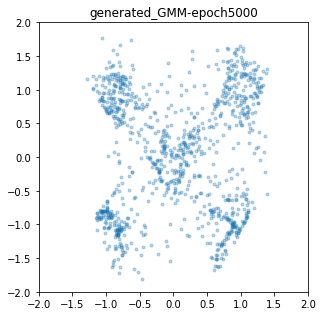

Epoch 5000, gen_loss: 0.67093, disc_loss: [1.3800639, 1.3716624, 1.3539307, 1.3936057, 1.376434, 1.3952141, 1.3871748, 1.3940393, 1.3712771, 1.3693233]. Time: 0.43 sec


In [27]:
EPOCHS = 5000
BATCH_SIZE = 32
gen_loss_log, disc_loss_log = train(target_partions,
                                    epochs=EPOCHS,
                                    batch_size=BATCH_SIZE)

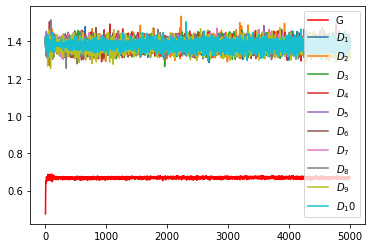

In [28]:
# loss curve
# generator
plt.plot(range(len(gen_loss_log)), gen_loss_log, 'r', label='G')

# discriminator
disc_loss_array = np.asarray(disc_loss_log)
for i in range(num_disc):
    plt.plot(range(disc_loss_array.shape[0]), disc_loss_array[:,i], label='$D_{}$'.format(i+1))

plt.legend()
plt.show()

# Quatitative evaluation 

In [45]:
noise = tf.random.normal([target_size, noise_dim])
generated_samples = generator(noise, training=False)

In [46]:
generated_samples.shape

TensorShape([5000, 2])

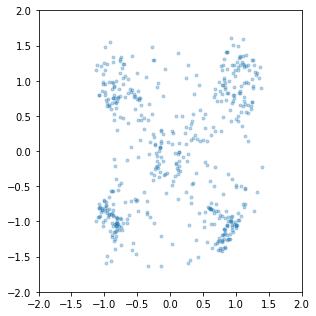

In [47]:
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

# axes.xaxis.set_visible(False)
# axes.yaxis.set_visible(False)

# plt.title('DCGAN')
axes.scatter(generated_samples[:500, 0],
             generated_samples[:500, 1],
             marker='.',
#              c=cm.Set1(train_labels.astype(float) / 2.0 / 2.0),
             alpha=0.3)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.tight_layout()
plt.show()